In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [7]:
from boruta import BorutaPy

In [8]:
data = pd.read_csv("/Users/leahuynh/Documents/DS Project/Customer-Churn-Prediction-Bank-/Data/Churn_Modelling.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Cleaning

In [9]:
# Check null values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
# Check whether there are duplicate values
data.duplicated().sum == True

False

In [11]:
#  Check unique values
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [12]:
data["Exited"].value_counts().index

Index([0, 1], dtype='int64', name='Exited')

# Data Visualization

Text(0.5, 1.0, 'Proportion of customer churned and retained')

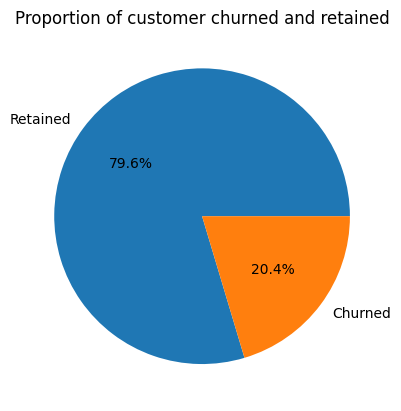

In [13]:
# Find proportion of churned customer in the dataset
label_map = {1: "Churned", 0: "Retained"}
labels = [label_map[i] for i in data["Exited"].value_counts().index]

fig, ax = plt.subplots()
ax.pie(data["Exited"].value_counts(),
       labels = labels,
       autopct = "%1.1f%%")
plt.title("Proportion of customer churned and retained")

<Axes: xlabel='IsActiveMember', ylabel='count'>

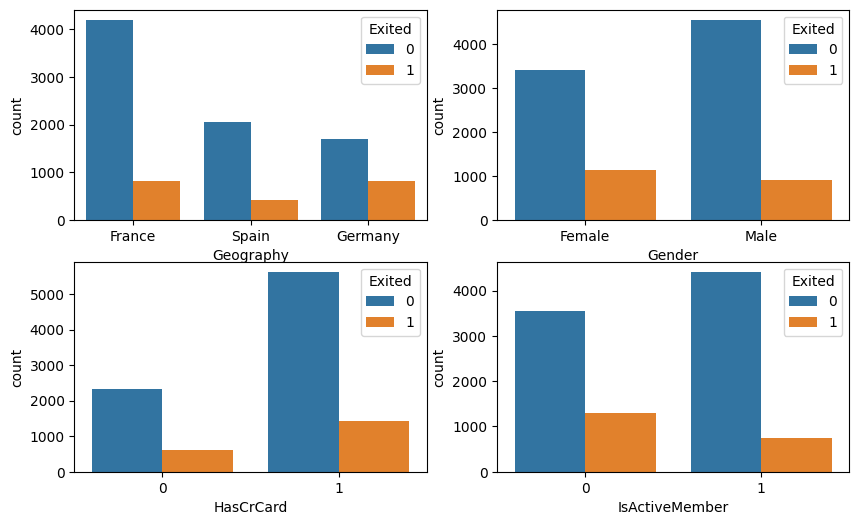

In [14]:
# The relation between churned status and categorical variables (Geography, Gender, Has Credit Card, is Active Member)
fig, ax = plt.subplots(2,2, figsize = (10,6))
sns.countplot(data = data, x = "Geography", hue = "Exited", ax = ax[0][0])
sns.countplot(data = data, x = "Gender", hue = "Exited", ax = ax[0][1])
sns.countplot(data = data, x = "HasCrCard", hue = "Exited", ax = ax[1][0])
sns.countplot(data = data, x = "IsActiveMember", hue = "Exited", ax = ax[1][1])

<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

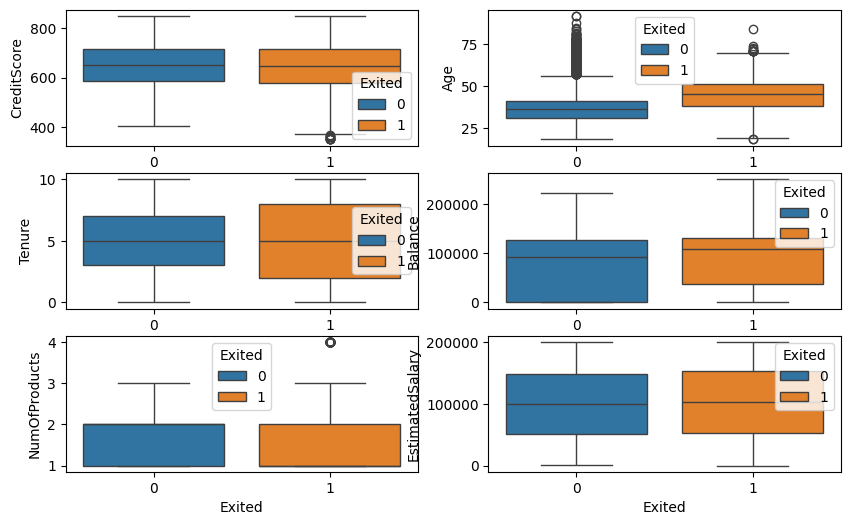

In [15]:
# The relation between churned status and continuous variables (CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary)
fig, ax = plt.subplots(3,2, figsize = (10,6))
sns.boxplot(data = data, x = "Exited", y = "CreditScore", hue = "Exited", ax = ax[0][0])
sns.boxplot(data = data, x = "Exited", y = "Age", hue = "Exited", ax = ax[0][1])
sns.boxplot(data = data, x = "Exited", y = "Tenure", hue = "Exited", ax = ax[1][0])
sns.boxplot(data = data, x = "Exited", y = "Balance", hue = "Exited", ax = ax[1][1])
sns.boxplot(data = data, x = "Exited", y = "NumOfProducts", hue = "Exited", ax = ax[2][0])
sns.boxplot(data = data, x = "Exited", y = "EstimatedSalary", hue = "Exited", ax = ax[2][1])

# Feature Engineering

In [17]:
# Add more features
data["balancePerEstimatedSalary"] = data["Balance"]/data["EstimatedSalary"]
data["tenurePerAge"] = data["Tenure"]/data["Age"]
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balancePerEstimatedSalary,tenurePerAge
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.190476
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025641
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0.000000,0.128205
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0.564108,0.285714
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,0.000000,0.194444
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,0.808230,0.071429


(-1.0, 7.0)

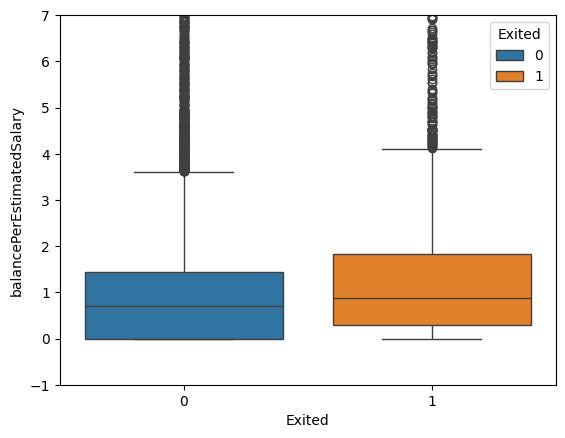

In [18]:
sns.boxplot(data = data, x = "Exited", y = "balancePerEstimatedSalary", hue = "Exited")
plt.ylim(-1, 7)

<Axes: xlabel='Exited', ylabel='tenurePerAge'>

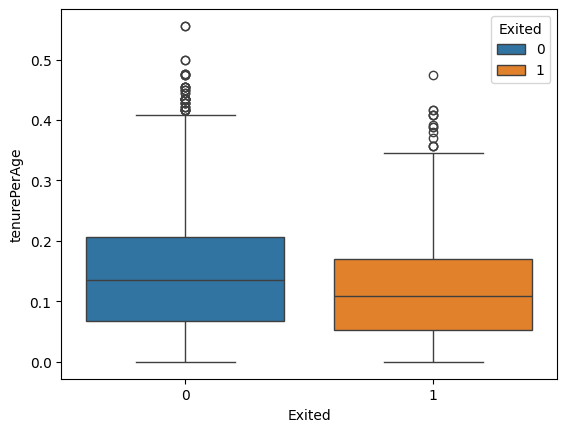

In [19]:
sns.boxplot(data = data, x = "Exited", y = "tenurePerAge", hue = "Exited")

In [20]:
# One Hot Encooding for categories data
data = pd.get_dummies(data = data, columns= ["Gender", "Geography"])


In [21]:
# Drop unnecessary columns
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])


In [23]:
# Scale the data using MinMaxScaler
scale_var = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = MinMaxScaler()
data[scale_var] = scaler.fit_transform(data[scale_var])


In [24]:
data

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balancePerEstimatedSalary,tenurePerAge,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
0,0.538,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,0.000000,0.047619,True,False,True,False,False
1,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0.744677,0.024390,True,False,False,False,True
2,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1.401375,0.190476,True,False,True,False,False
3,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,0.000000,0.025641,True,False,True,False,False
4,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,1.587055,0.046512,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.842,0.283784,0.5,0.000000,0.333333,1,0,0.481341,0,0.000000,0.128205,False,True,True,False,False
9996,0.332,0.229730,1.0,0.228657,0.000000,1,1,0.508490,0,0.564108,0.285714,False,True,True,False,False
9997,0.718,0.243243,0.7,0.000000,0.000000,0,1,0.210390,1,0.000000,0.194444,True,False,True,False,False
9998,0.844,0.324324,0.3,0.299226,0.333333,1,0,0.464429,1,0.808230,0.071429,False,True,False,True,False


# Features Selection

- The visualizations suggest Age, Balance, and NumOfProducts can be the potential features.
- Now, we will use other methods to confirm or add-in more features encoded

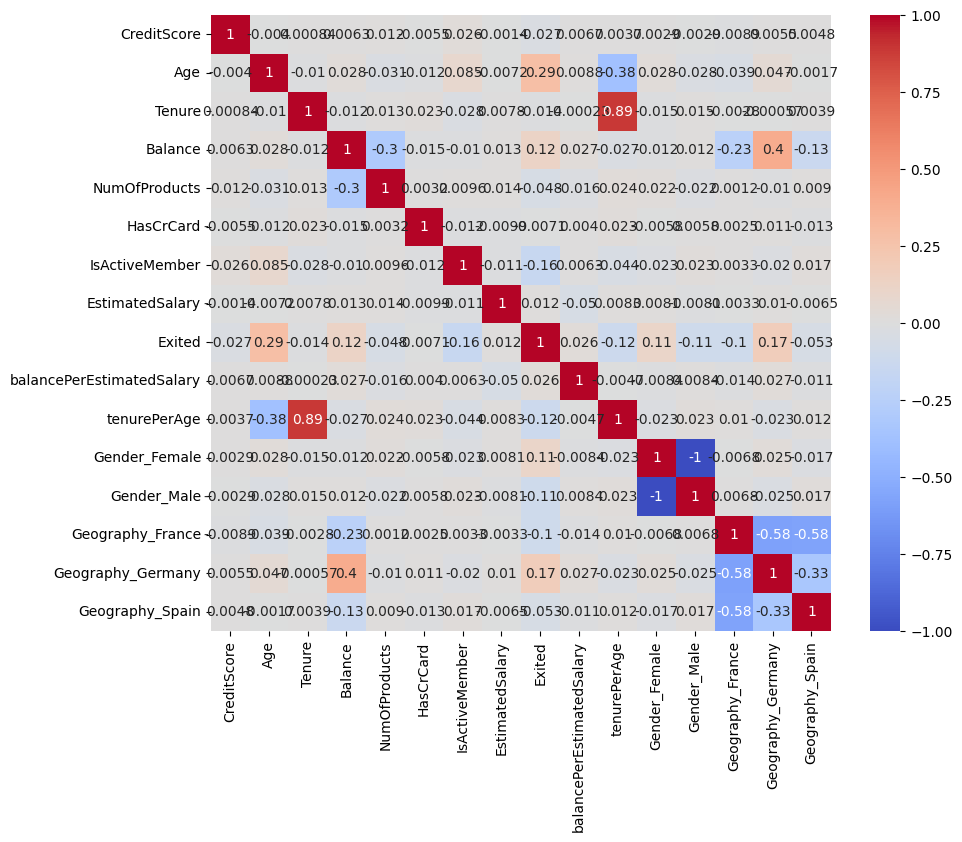

In [28]:
# Heat map
corr_map = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_map, annot=True, cmap='coolwarm')
plt.show()

In [42]:
# Use boruta methods
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

x = data.drop("Exited", axis= "columns")
y = data["Exited"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 49)

boruta.fit(x, y)
selected_features = boruta.support_

x.iloc[:, selected_features].columns

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	11


Index(['Age', 'Balance', 'NumOfProducts', 'tenurePerAge'], dtype='object')

# Split The Data

In [47]:
x_selected_features = x.iloc[:, selected_features]
x_train, x_test, y_train, y_test = train_test_split(x_selected_features, y, test_size= 0.2, random_state= 49)

# Building Models

In [58]:
def model_accuracy_skf(x, y, model):
    skf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)

    # reports for each fold
    reports = []
    accuracy = []
    precision = []
    recall = []
    f1_score = []
    for train_index, test_index in skf.split(x,y):
        xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        model.fit(xtrain, ytrain)
        y_predict = model.predict(xtest)
        reports.append(classification_report(ytest, y_predict, output_dict= True))

    for report in reports:
        accuracy.append(report['accuracy'])
        precision.append(report['weighted avg']['precision'])
        recall.append(report['weighted avg']['recall'])
        f1_score.append(report['weighted avg']['f1-score'])
    
    return pd.DataFrame({'Mean accuracy': np.round(np.mean(accuracy), 2),
                         'Mean precision': np.round(np.mean(precision), 2),
                         'Mean recall': np.round(np.mean(recall), 2),
                         'Mean f1_score': np.round(np.mean(f1_score), 2)
                         }, index = [model])


### Baseline Model


In [51]:
dummy = DummyClassifier()
dummy.fit(x_train, y_train)

DummyClassifier()

In [53]:
y_predict_dummy = dummy.predict(x_test)


In [54]:
accuracy_score(y_test, y_predict_dummy)

0.778

In [55]:
print(classification_report(y_test, y_predict_dummy))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1556
           1       0.00      0.00      0.00       444

    accuracy                           0.78      2000
   macro avg       0.39      0.50      0.44      2000
weighted avg       0.61      0.78      0.68      2000



/opt/anaconda3/envs/py3119/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/py3119/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/py3119/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
# Cross Validation
result_dummy = model_accuracy_skf(x_selected_features, y, dummy)
result_dummy

/opt/anaconda3/envs/py3119/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/py3119/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/py3119/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

,Mean accuracy,Mean precision,Mean recall,Mean f1_score
DummyClassifier(),0.8,0.63,0.8,0.71


### Support Vector Machine

In [59]:
svm = SVC(class_weight="balanced")
svm.fit(x_train, y_train)
y_predict_svm = svm.predict(x_test)

In [60]:
print(classification_report(y_test, y_predict_svm))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1556
           1       0.49      0.74      0.59       444

    accuracy                           0.77      2000
   macro avg       0.70      0.76      0.72      2000
weighted avg       0.82      0.77      0.79      2000



In [61]:
accuracy_score(y_test, y_predict_svm)

0.774

In [77]:
# Cross Validation
result_svm = model_accuracy_skf(x_selected_features, y, svm)
result_svm

,Mean accuracy,Mean precision,Mean recall,Mean f1_score
SVC(class_weight='balanced'),0.77,0.83,0.77,0.79


### XGBoost

In [65]:
xgb = XGBClassifier(random_state = 42, scale_pos_weight = 4)
xgb.fit(x_train, y_train)
y_predict_xgboost = xgb.predict(x_test)
# scale_pos_weight - balance of positive and negative weights, sum(negative) / sum(positive)

In [66]:
accuracy_score(y_test, y_predict_xgboost)

0.784

In [67]:
print(classification_report(y_test, y_predict_xgboost))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1556
           1       0.51      0.64      0.57       444

    accuracy                           0.78      2000
   macro avg       0.70      0.73      0.71      2000
weighted avg       0.81      0.78      0.79      2000



In [81]:
result_xgb = model_accuracy_skf(x_selected_features, y, xgb)
result_xgb

,Mean accuracy,Mean precision,Mean recall,Mean f1_score
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=None, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=None,\n n_jobs=None, num_parallel_tree=None, ...)",0.77,0.81,0.77,0.78


### Lightgbm

In [74]:
lightgbm = LGBMClassifier(random_state=42, class_weight='balanced')
lightgbm.fit(x_train, y_train)
y_predict_lightgbm = lightgbm.predict(x_test)


[LightGBM] [Info] Number of positive: 1593, number of negative: 6407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [75]:
model_accuracy_skf(x, y, lightgbm)

[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1359
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] 

,Mean accuracy,Mean precision,Mean recall,Mean f1_score
"LGBMClassifier(class_weight='balanced', random_state=42)",0.82,0.84,0.82,0.83


In [82]:
result_lightgbm = model_accuracy_skf(x_selected_features, y, lightgbm)
result_lightgbm

[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Numb

,Mean accuracy,Mean precision,Mean recall,Mean f1_score
"LGBMClassifier(class_weight='balanced', random_state=42)",0.77,0.82,0.77,0.79


### Model Accuracy Summarization

In [98]:
result = pd.concat([result_dummy, result_svm, result_xgb, result_lightgbm], axis= 0)
result

,Mean accuracy,Mean precision,Mean recall,Mean f1_score
DummyClassifier(),0.80,0.63,0.80,0.71
SVC(class_weight='balanced'),0.77,0.83,0.77,0.79
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=None, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=None,\n n_jobs=None, num_parallel_tree=None, ...)",0.77,0.81,0.77,0.78
"LGBMClassifier(class_weight='balanced', random_state=42)",0.77,0.82,0.77,0.79


- SVC and LGBMClassifier are the top contenders since they have the best precision, recall, and F1-score balance.
- If interpretability and efficiency matter, LGBMClassifier is a strong choice.
- If prioritize precision (reducing false positives), SVC is ideal.

### Sequential model

In [99]:
x_train_deep, x_test_deep, y_train_deep, y_test_deep = train_test_split(x, y, test_size= 0.2, random_state= 49)

In [101]:
model = keras.Sequential([
    keras.layers.Dense(12, input_shape=(15,), activation='relu'), 
    #relu to make sure the network can learn non-linear relationships
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') 
    #sigmoid for the binary classification
])

/opt/anaconda3/envs/py3119/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [102]:
model.compile(optimizer='adam', # Adam optimizer for adjusting weights
              loss='binary_crossentropy', # Since it's a binary classification problem
              metrics=['accuracy'] 
              )

In [103]:
model.fit(x_train_deep, 
          y_train_deep,
          epochs=100) # How many times to go through the entire dataset

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7485 - loss: 0.7520
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7878 - loss: 0.4890
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8023 - loss: 0.4587
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8104 - loss: 0.4672
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8169 - loss: 0.4515
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8131 - loss: 0.4440
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8146 - loss: 0.4447
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8226 - loss: 0.4293
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8156 - loss: 0.4431
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8045 - loss: 0.4892
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8228 - loss: 0.4252
Epoch 12/100
250/250 ━━━━━━━━━

In [104]:
predict_sequential = model.predict(x_test_deep)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### Convert our prediction to 0, 1

In [105]:
y_predict = []
for i in predict_sequential:
    if i > 0.5:
        y_predict.append(1)
    else:
        y_predict.append(0)

#### Check model accuracy

In [106]:
model.evaluate(x_test_deep, y_test_deep)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7913 - loss: 0.4637


[0.4643206298351288, 0.796999990940094]

In [107]:
accuracy_score(y_test_deep, y_predict)

0.797

Text(95.72222222222221, 0.5, 'Actual')

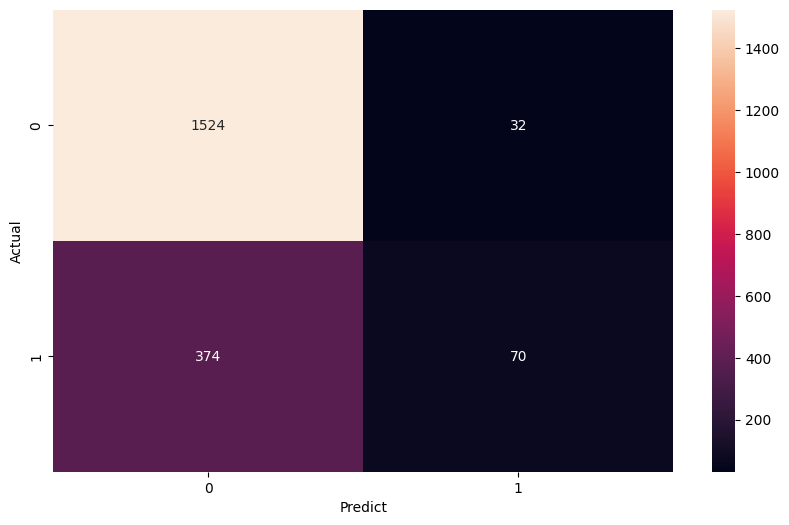

In [108]:
confusion_matrix = tf.math.confusion_matrix(labels=y_test_deep, predictions=y_predict)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix, annot = True, fmt='d')
plt.xlabel('Predict')
plt.ylabel('Actual')

In [109]:
print(classification_report(y_test_deep, y_predict))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1556
           1       0.69      0.16      0.26       444

    accuracy                           0.80      2000
   macro avg       0.74      0.57      0.57      2000
weighted avg       0.78      0.80      0.74      2000



In [110]:
print("Accuracy score: ", accuracy_score(y_test, y_predict) * 100, '%')

Accuracy score:  79.7 %


### Hyperparameter Fine Tuning for SVM Model

In [115]:
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01],
    'class_weight': ['balanced', {0: 1, 1: 4}, None]
}

In [116]:
gs = GridSearchCV(SVC(), 
                  param_grid=params, 
                  scoring='f1', 
                  cv=StratifiedKFold(n_splits=5))

gs.fit(x_selected_features, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', {0: 1, 1: 4}, None],
                         'gamma': ['scale', 1, 0.1, 0.01],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1')

In [117]:
best_params = gs.best_params_
best_params

{'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}

In [118]:
svc_gs = SVC(
    C=best_params['C'],
    class_weight=best_params['class_weight'],
    gamma=best_params['gamma'],
    kernel=best_params['kernel']
)
svc_gs.fit(x_train, y_train)
y_predict_svm_gs = svc_gs.predict(x_test)
print(classification_report(y_test, y_predict_svm_gs))
print(accuracy_score(y_test, y_predict_svm_gs))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1556
           1       0.49      0.74      0.59       444

    accuracy                           0.77      2000
   macro avg       0.70      0.76      0.72      2000
weighted avg       0.82      0.77      0.79      2000

0.774


In [119]:
result_svm_gs = model_accuracy_skf(x_selected_features, y, svc_gs)
result_svm_gs

,Mean accuracy,Mean precision,Mean recall,Mean f1_score
"SVC(C=1, class_weight='balanced')",0.77,0.83,0.77,0.79


In [120]:
result = pd.concat([result, result_svm_gs], axis=0)
result

,Mean accuracy,Mean precision,Mean recall,Mean f1_score
DummyClassifier(),0.80,0.63,0.80,0.71
SVC(class_weight='balanced'),0.77,0.83,0.77,0.79
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=None, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=None,\n n_jobs=None, num_parallel_tree=None, ...)",0.77,0.81,0.77,0.78
"LGBMClassifier(class_weight='balanced', random_state=42)",0.77,0.82,0.77,0.79
"SVC(C=1, class_weight='balanced')",0.77,0.83,0.77,0.79


In [179]:
# model deploy:
# https://github.com/juniorcl/churn-prediction/blob/main/notebooks/cycle3-churn-prediction.ipynb
